# Nhận diện khuôn mặt (Face recognition)
_____
Hiện nay có nhiều phương pháp để thực hiện bài toán xác thực khuôn mặt, phương pháp phổ biến nhất là thực hiện bài toán phân loại (Classifier) sử dụng mô hình CNN (Convolutional Neural Network) trên tập dữ liệu với các label có sẵn. Nhưng các mô hình CNN thường mất rất nhiều thời gian để huấn luyện (train) mô hình, tập dữ liệu càng lớn thì thời gian huấn luyện càng lâu. Hơn nữa, nếu dùng phương pháp này, chúng ta chỉ nhận diện được những khuôn mặt đã có, không thể nhận diện thêm được những khuôn mặt do người dùng bổ sung vào. Đối với những bài toán có tập dữ liệu lớn và yêu cầu phải thực hiện theo thời gian thực thì phương pháp trên tỏ ra không hiệu quả.

Để khắc phục khuyết điểm trên, tôi giới thiệu một phương pháp giải quyết là sử dụng mô hình MTCNN cho bài toán xác định khuôn mặt. Sau đó sẽ dùng mô hình CNN Pretrain để trích xuất đặc trưng khuôn mặt của người đó và thêm vào tập dữ liệu hiện có. Cuối cùng, tùy vào yêu cầu cụ thể sẽ áp dụng các thuật toán Machine Learning, đồ thị (Graph) hoặc vector để tìm ra dữ liệu tương đồng giữa dữ liệu đầu vào và dữ liệu hiện có, từ đó xác định được khuôn mặt đưa vào là ai?

![Image](images/face_recognition_step.png)

Do phương pháp này không cần huấn luyện toàn bộ tập dữ liệu hiện có mà chỉ huấn luyện những dữ liệu mới nên cải thiện được rất đáng kể thời gian huấn luyện. Phương pháp này có thể áp dụng vào bài toán xác định các thành viên trong tổ công tác (chương trình Quản lý An toàn EVN SPC).

Phương pháp này bao gồm các bước như hình trên:
* Face Detection: đây là quá trình phát hiện có gương mặt trong ảnh, video hay không. Thuật toán sử dụng phổ biến nhất hiện nay là Viola Jones. Thư viện OpenCV sử dụng thuật toán này để phát hiện khuôn mặt.
* Embedding Vector:
* Face Recognization: đây mới là quá trình nhận diện khuôn mặt. Từ kết quả của các bước trước, ta xác định được khuôn mặt có trong ảnh. Các khuôn mặt này sẽ lần lượt được so sánh với các khuôn mặt đã có trong tập dữ liệu để tìm khuôn mặt giống nhất.

## Các thư viện sử dụng
Trong bài viết này, chúng ta thực hiện nhận diện khuôn mặt bằng các thư viện sau:
* MTCNN: Multi Tast Cascaded Convolutional Neural Network được giới thiệu năm 2016 bởi Zhang, thư viện có khả năng phát hiện khuôn mặt cho dù không hề được chụp chính diện.
* OpenCV: là một thư viện xử lý hình ảnh và video được dùng để phân tích hình ảnh chỉnh sửa ảnh, thị giác máy tính, nhận diện ký tự quang học,...
* VGGFace: được phát triển bởi các nhà khoa học thuộc Đại học Oxford, được sử dụng để trích xuất đặc trưng của khuôn mặt
* skimage: là một tập hợp các thuật toán để xử lý hình ảnh trong python. Trong bài viết này, tôi sử dụng skimage để hiển thị ảnh ra màn hình.
* Ngoài ra còn sử dụng các thư viện khác như: Pandas, Numpy, Matplotlib, Scipy.

In [1]:
import cv2
from skimage import io
from PIL import Image

from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

import tensorflow as tf
import scipy.spatial.distance as distance
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Face detection (phát hiện khuôn mặt)
Face detection là quá trình tự động định vị các khuôn mặt trong một bức ảnh và khoanh vùng chúng bằng cách vẽ một khung quanh khuôn mặt gọi là bounding box. Có nhiều cách phát hiện khuôn mặt như sử dụng: Haar Cascade, LBP Cascade (có trong thư viện OpenCV) hoặc MTCNN. Trong ứng dụng 'Quản lý an toàn', ảnh được chụp từ camera điện thoại có độ nét cao. Do đó chúng ta sử dụng MTCNN. Đây là thuật toán tương đối nhanh và chính xác, tuy nhiên lại kém hiệu quả trên các ảnh có chất lượng kém, mờ.


In [2]:
# define face detection function
def faces_detect(image):
    detector = MTCNN()
    faces = detector.detect_faces(image)
    return faces

Kết quả là danh sách bounding box, mỗi bounding box xác định vị trí góc trên bên trái kèm chiều dài và chiều rộng của khuôn mặt. Ngoài ra còn có vị trí mắt trái, mắt phải, mũi, mép trái và phải của miệng.

In [3]:
# load image
filename = 'images/my_family_1.jpg'
image = io.imread(filename)
    
# get face count and bounding box
faces = faces_detect(image)

print('face count: ', len(faces), '\n')
for face in faces:
    print(face, '\n')

face count:  4 

{'box': [281, 178, 137, 182], 'confidence': 0.9999773502349854, 'keypoints': {'left_eye': (327, 252), 'right_eye': (387, 259), 'nose': (358, 286), 'mouth_left': (324, 312), 'mouth_right': (376, 317)}} 

{'box': [503, 286, 127, 160], 'confidence': 0.9999386072158813, 'keypoints': {'left_eye': (534, 353), 'right_eye': (590, 342), 'nose': (566, 376), 'mouth_left': (546, 405), 'mouth_right': (600, 394)}} 

{'box': [263, 480, 119, 162], 'confidence': 0.9993963241577148, 'keypoints': {'left_eye': (290, 547), 'right_eye': (346, 549), 'nose': (314, 581), 'mouth_left': (294, 607), 'mouth_right': (336, 609)}} 

{'box': [523, 561, 116, 151], 'confidence': 0.9970511198043823, 'keypoints': {'left_eye': (553, 624), 'right_eye': (608, 618), 'nose': (583, 649), 'mouth_left': (562, 677), 'mouth_right': (610, 672)}} 



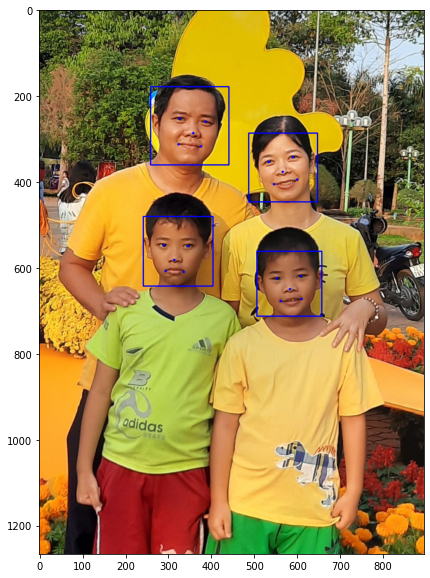

In [4]:
for face in faces:
    keypoints = face['keypoints']
    x, y, width, height = face['box']
    
    if (width < height):
        x = x - (height - width)//2
        width = height
    elif (width > height):
        y = y - (width - height)//2
        height = width
    
    #draw bounding box
    cv2.rectangle(image, (x, y), (x+width, y+ height), (0, 0, 255), 2)
    #draw 
    cv2.circle(image, (keypoints['left_eye']), 1, (0, 0, 255), 3)
    cv2.circle(image, (keypoints['right_eye']), 1, (0, 0, 255), 3)
    cv2.circle(image, (keypoints['nose']), 1, (0, 0, 255), 3)
    cv2.circle(image, (keypoints['mouth_left']), 1, (0, 0, 255), 3)
    cv2.circle(image, (keypoints['mouth_right']), 1, (0, 0, 255), 3)

plt.figure(figsize=(15,10))
plt.imshow(image)
plt.show()

## Extract faces from image
Extract faces là quá trình cắt các khuôn mặt nhỏ có trong hình ảnh được xác định từ bước face detection. Các khuôn mặt nhỏ được cắt ra có thể được lưu vào dataset để sử dụng sau này. Sau đó, chúng ta có thể sử dụng thư viện PIL để thay đổi kích thước hình ảnh các khuôn mặt nhỏ này thành kích thước cần thiết để sử dụng cho các bước sau.

In [6]:
def faces_extract(image, required_size=(224, 224)):
    faces = faces_detect(image)
    
    faces_extract = []
    for i in range(len(faces)):
        # get coordinates
        x1, y1, width, height = faces[i]['box']
        
        if (width < height):
            x1 = x1 - (height - width)//2
            width = height
        elif (width > height):
            y1 = y1 - (width - height)//2
            height = width
        x2, y2 = x1 + width, y1 + height

        # Calculating a center point of small face
        center = (width // 2, height // 2)

        # get keypoint (face landmarks)
        keypoints = faces[i]['keypoints']
        left_eye_x, left_eye_y = keypoints['left_eye']
        right_eye_x, right_eye_y = keypoints['right_eye']

        # compute arctan
        delta_x = right_eye_x - left_eye_x
        delta_y = right_eye_y - left_eye_y
        angle = np.arctan(delta_y/delta_x)
        angle = (angle * 180) / np.pi

        # alingment face
        M = cv2.getRotationMatrix2D(center, (angle), 1.0)
        rotated = cv2.warpAffine(image[y1:y2, x1:x2], M, (width, height))

        # extract face
        face_img = Image.fromarray(rotated)
        face_img = face_img.resize(required_size)
        face_array = np.asarray(face_img)
        faces_extract.append(face_array)
        
    return faces_extract

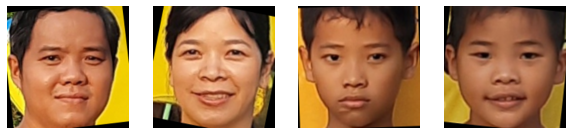

In [7]:
# load image
filename = 'images/my_family_1.jpg'
image = io.imread(filename)

# extract face
faces = faces_extract(image, (224, 224))

# show extract face
plt.figure(figsize=(10, 8))
for i in range(len(faces)):
    # define subplot
    plt.subplot(1, len(faces), i+1)
    plt.axis('off')
    # plot face
    plt.imshow(faces[i])

# show the plot
plt.show()   

## Generate embedding vector
Việc tiếp theo chúng ta cần làm là biểu diễn các khuôn mặt này dưới dạng vector đặc trưng trước khi đưa vào các mô hình dự đoán. Quá trình này gọi là trích xuất đặc trưng (embedding) của ảnh. Một số pretrain model để thực hiện là gồm FaceNet, ArcFace, VGGFace, nn4. Để khách quan, ta áp dụng từng mô hình để trích xuất embedding. 

### VGG_Face
VGG_Face được đào tạo trên hàng triệu hình ảnh để nhận dạng các khuôn mặt được gắn nhãn trong tự nhiên. Đầu vào của mô hình là một ảnh có kích thước (224, 224, 3). Embedding của mô hình này là một vector có độ dài 2048 chiều. 

In [ ]:
# create a vggface2 model
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
#C:\Users\minhl\.keras\models\vggface
# summarize input and output shape
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

Định nghĩa hàm generate embedding để dễ sử dụng

In [9]:
def get_embedding_vgg(faces_extract):
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    
    samples = np.asarray(faces_extract, 'float32')
    samples = preprocess_input(samples, version=2)

    embeddings = model.predict(samples)
    return embeddings

In [10]:
embeddings = get_embedding(faces)
embeddings

array([[0.0000000e+00, 6.6978793e+00, 0.0000000e+00, ..., 2.3052542e+00,
        0.0000000e+00, 2.6369508e-02],
       [5.5825945e-02, 9.7508502e-01, 7.2652191e-02, ..., 0.0000000e+00,
        0.0000000e+00, 3.1310391e-01],
       [3.2137511e-03, 3.0906847e+00, 2.9234626e+00, ..., 9.3673623e-01,
        1.6933412e-03, 7.5253069e-01],
       [0.0000000e+00, 2.7294331e+00, 1.5673909e+00, ..., 4.3563064e-02,
        2.3958134e-02, 6.8980908e-01]], dtype=float32)

In [11]:
embeddings.shape

(4, 2048)

### FaceNet
FaceNet là một hệ thống nhận dạng khuôn mặt được giới thiệu bởi Florian Schroff tại Google vào năm 2015. Đầu vào của FaceNet là một ảnh có kích thước (160, 160, 3). Vector embedding được trích xuất có độ dài 128 chiều.

In [8]:
from keras.models import load_model

# load FaceNet model
model = load_model('models/facenet_keras.h5')

# summarize input and output shape
print(model.inputs)
print(model.outputs)

Định nghĩa hà generate embedding sử dụng FaccNet

In [ ]:
def get_embedding_facenet(faces_extract):
    # scale pixel values
	#face_pixels = faces_extract.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	faces_extract = (faces_extract - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

## Save embedding
Để xác định được vector đặc trưng được trích xuất là của ai, ta tiến hành gán nhãn cho các đặc trưng vừa trích xuất được.

In [10]:
names = ['Dad', 'Mom', 'Chip', 'Tool']
list_tuples = list(zip(embeddings, names))  

df = pd.DataFrame(list_tuples, columns=['embedding', 'label']) 
df.head()

,embedding,label
0,"[0.0, 6.6978793, 0.0, 2.2355115, 0.65430886, 2...",Dad
1,"[0.055825945, 0.975085, 0.07265219, 0.04561711...",Mom
2,"[0.0032137511, 3.0906847, 2.9234626, 0.0, 0.00...",Chip
3,"[0.0, 2.729433, 1.5673909, 0.0, 0.14194474, 1....",Tool


Để sử dụng các đặc trưng này cho những lần dự đoán sau, chúng ta sẽ lưu đặc trưng của các khuôn mặt vừa trích xuất được cùng với nhãn của chúng để phân biệt vào một file pickle.

In [54]:
#use pickle to save data into a file for later use
f = open("face_dataset", "wb")
f.write(pickle.dumps(df))
f.close()

Bây giờ chúng ta đã lưu trữ đặc trưng của khuôn mặt kèm nhãn nhận diện vào một file có tên “face_dataset”. File này có thể xem là tập dữ liệu gốc chứa những khuôn mặt đã được nhận diện. Chúng ta có thể sử dụng tập tin này để nhận dạng khuôn mặt trong hình ảnh hoặc video.

In [15]:
#load data from pickle
f = open("face_dataset", "rb")
df = pickle.loads(f.read())
df.head()

,embedding,label
0,"[0.0, 6.6978793, 0.0, 2.2355115, 0.65430886, 2...",Dad
1,"[0.055825945, 0.975085, 0.07265219, 0.04561711...",Mom
2,"[0.0032137511, 3.0906847, 2.9234626, 0.0, 0.00...",Chip
3,"[0.0, 2.729433, 1.5673909, 0.0, 0.14194474, 1....",Tool
4,"[0.0, 2.1588497, 3.409771, 0.0, 4.447153, 2.60...",Chip


In [17]:
df.shape

(16, 2)

## Face recognition
Đây là bước cuối cùng trong bài toán để xác định xem các khuôn mặt trong ảnh là của những ai. Để xác định, chúng ta tính khoản cách cosine giữa embedding khuôn mặt cần nhận diện với các embedding trong tập dữ liệu. Khoảng cách cosine trả về giá trị từ 0 đến 1 phản ánh hướng của 2 vector. Nếu khoảng cách cosin gần 0 thì hai vectơ có hướng tương tự và gần nhau. Nếu nó gần bằng 1 thì hai vectơ khác nhau. Do đó phải tìm một ngưỡng (threshold) phù hợp để quyết định khuôn mặt đang nhận diện là của người đã được xác định trong tập dữ liệu hay chưa.

**Find distance threashold (tìm ngưỡng)**

Để tìm giá ngưỡng phù hợp cho khoảng cách, chúng ta phải đánh giá kết quả xác định khuôn mặt trên một loạt các giá trị ngưỡng giả định. Ở mỗi ngưỡng giả định, chúng ta sẽ so sánh khoảng cách giữa 2 embedding vector để xác định 2 khuôn mặt là giống hay khác nhau, từ đó so sánh với thực tế. Giá trị nào cho kết quả tốt nhất sẽ được chọn.

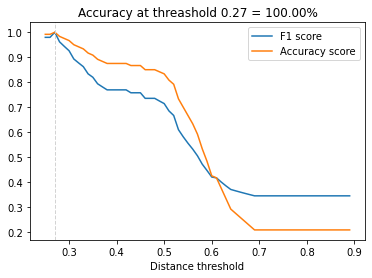

In [32]:
from sklearn.metrics import f1_score, accuracy_score

distances = []
identical = []

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        #dis = distance.euclidean(df.at[i, 'embedding'], df.at[j, 'embedding'])
        #dis = np.linalg.norm(df.at[i, 'embedding'], df.at[j, 'embedding'])
        dis = distance.cosine(df.at[i, 'embedding'], df.at[j, 'embedding'])
        distances.append(dis)
        identical.append(1 if df.at[i, 'label'] == df.at[j, 'label'] else 0)
        
distances = np.array(distances)
identical = np.array(identical)
#print(distances)

thresholds = np.arange(0.25, 0.9, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
opt_tau = thresholds[opt_idx]
opt_acc = accuracy_score(identical, distances < opt_tau)
opt_acc = opt_acc * 100

plt.plot(thresholds, f1_scores, label='F1 score')
plt.plot(thresholds, acc_scores, label='Accuracy score')
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey')
plt.title(f'Accuracy at threashold {opt_tau:.2f} = {opt_acc:.2f}%')
plt.xlabel('Distance threshold')
plt.legend();
plt.show()

Dựa vào biểu đồ trên, ta thấy tại ngưỡng (threashold) = 0.27 sẽ cho kết quả tốt nhất (F1 score = 100%). Có nghĩa là tại threashold = 0.27 các khuôn mặt được phân biệt và nhận diện chính xác 100%. Như vậy ta chọn ngưỡng là 0.27, có thể +/- 0.05. Hai biểu đồ sau đây biểu diễn sự phân bố khoảng cách giữa 2 khuôn mặt giống nhau (positive pairs) và khác nhau (negative pairs) và vị trí của ngưỡng. 

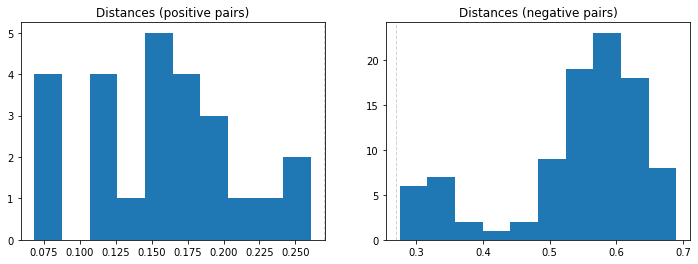

In [33]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey')
plt.title('Distances (positive pairs)')

plt.subplot(1, 2, 2)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey')
plt.title('Distances (negative pairs)')

plt.show()

**Face recognition**

Khi đã xác định được ngưỡng của khoảng cách giữa 2 khuôn mặt, việc nhận diện khuôn mặt chỉ đơn giản là tính khoảng cách giữa embedding với từng khuôn mặt trong tập dữ liệu. Với những khuôn mặt có khoảng cách lớn hơn ngưỡng, ta xác định đó là một người lạ (Unknow), tức là người chưa có trong tập dữ liệu. Những khuôn mặt có khoảng cách bé hơn ngưỡng sẽ được xác định label tương ứng.

In [35]:
def face_match(dataframe, embedding, thresh=0.35):
    label = 'Unknow'
    
    # compute dítance to all point in dataframe
    distances = [distance.cosine(x, embedding) for x in dataframe['embedding']]
    # get three index smalless distance in list
    top_idxs = np.argsort(distances)[:3]
    index = Counter(top_idxs).most_common(1)[0][0]
    
    dis = distances[index]
    if (dis <= thresh):
        label = dataframe['label'][index]
    
    return (label, dis)

def faces_match(dataframe, list_embedding, thresh=0.35):
    y_pred = [face_match(dataframe, embedding, thresh) for embedding in list_embedding]
    return y_pred

def is_match(data, embeddings, thresh=0.35): 
	# calculate distance between embeddings
	score = distance.cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

In [36]:
y_red = faces_match(df, embeddings) 
y_red

[('Dad', 0.0), ('Mom', 0.0), ('Chip', 0.0), ('Tool', 0.0)]

## Test image

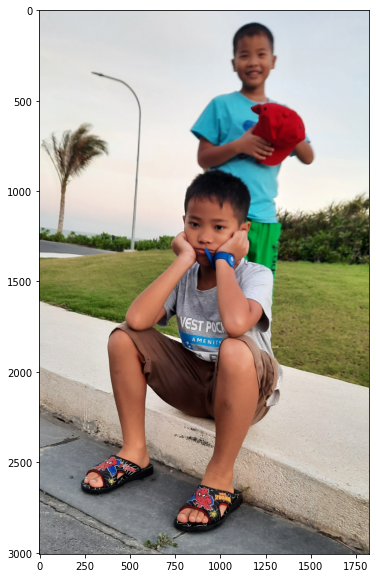

In [38]:
test_file = 'images/20210711_103331.jpg'
test_image = io.imread(test_file)

plt.figure(figsize=(15,10))
plt.imshow(test_image)
plt.show()

Take 10.823973 seconds to recognize.


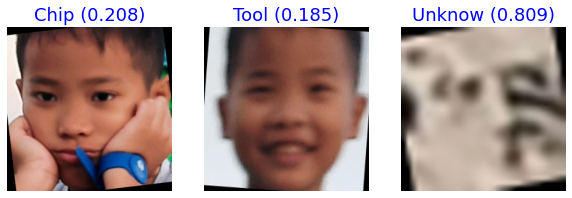

In [39]:
import time
start_time = time.time()

# extract faces
test_faces = faces_extract(test_image)
# generate embedding
embeddings = get_embedding(test_faces)
# face recognition
results = faces_match(df, embeddings)

end_time = time.time()-start_time
print("Take %f seconds to recognize." %end_time)

plt.figure(figsize=(10, 8))
# plot each face as a subplot
for i in range(len(test_faces)):
    # define subplot
    plt.subplot(1, len(test_faces), i+1)
    plt.axis('off')
    # plot face
    plt.imshow(test_faces[i])
    #plt.xlabel(results[i], fontsize=18, color='blue')
    title = "{0} ({1})".format(results[i][0], round(results[i][1], 3))
    plt.title(title, fontsize=18, color='blue')

# show the plot
plt.show() 